## Load packages + data

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from scipy.stats import pearsonr
from sklearn.frozen import FrozenEstimator
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


### reading data

In [3]:
chunksize = 100

list_of_dataframes = []

for df in pd.read_csv('MeanImputedScaledData.csv', chunksize=chunksize, index_col=0):
    list_of_dataframes.append(df)

result = pd.concat(list_of_dataframes)
df = result

ax_columns = [col for col in df.columns if col.startswith('AX')]
# len(ax_columns)
X = df[ax_columns]
y = df["Status"]
X = X.to_numpy()
y = y.to_numpy()

scaler = StandardScaler()
X = scaler.fit_transform(X)
X

array([[-0.81812574, -0.76982067, -0.02041218, ...,  0.        ,
         0.        ,  0.        ],
       [-0.81812574, -0.76982067, -0.02041218, ...,  0.        ,
         0.        ,  0.        ],
       [-0.81812574, -0.76982067, -0.02041218, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.81812574, -0.76982067, -0.02041218, ...,  0.        ,
         0.        ,  0.        ],
       [-0.81812574, -0.76982067, -0.02041218, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.90392783,  2.18940958, -0.02041218, ...,  0.        ,
         0.        ,  0.        ]])

In [4]:
df['ID'] = df.index
ids = df["ID"].to_numpy()

## predict proba

### LR/GB/RF first pass

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [5]:
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)
lr_probs = lr_model.predict_proba(X_test)
print("\nLogistic Regression Probabilities:\n", lr_probs)

gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)
gb_probs = gb_model.predict_proba(X_test)
print("Gradient Boosting Probabilities:\n", gb_probs)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_probs = rf_model.predict_proba(X_test)
print("\nRandom Forest Probabilities:\n", rf_probs)



Logistic Regression Probabilities:
 [[1.84671139e-03 9.98153289e-01]
 [1.20882052e-06 9.99998791e-01]
 [2.19739667e-01 7.80260333e-01]
 ...
 [2.90755619e-07 9.99999709e-01]
 [1.35696387e-07 9.99999864e-01]
 [8.66695999e-03 9.91333040e-01]]
Gradient Boosting Probabilities:
 [[0.38311932 0.61688068]
 [0.7361797  0.2638203 ]
 [0.17926464 0.82073536]
 ...
 [0.33889658 0.66110342]
 [0.08192517 0.91807483]
 [0.32330675 0.67669325]]

Random Forest Probabilities:
 [[0.35 0.65]
 [0.46 0.54]
 [0.32 0.68]
 ...
 [0.37 0.63]
 [0.24 0.76]
 [0.49 0.51]]


#### optional (?) calibration

In [ ]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_calib, y_train, y_calib = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

# --- Logistic Regression ---
lr_base = LogisticRegression(max_iter=1000, random_state=42)
lr_base.fit(X_train, y_train)
lr_frozen = FrozenEstimator(lr_base)
lr_calibrated = CalibratedClassifierCV(lr_frozen, cv=3, method='sigmoid')
lr_calibrated.fit(X_calib, y_calib)
lr_probs_cal = lr_calibrated.predict_proba(X_test)
print("\nCalibrated Logistic Regression Probabilities:\n", lr_probs_cal)

# --- Gradient Boosting ---
gb_base = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_base.fit(X_train, y_train)
gb_frozen = FrozenEstimator(gb_base)
gb_calibrated = CalibratedClassifierCV(gb_frozen, cv=3, method='sigmoid')
gb_calibrated.fit(X_calib, y_calib)
gb_probs_cal = gb_calibrated.predict_proba(X_test)
print("\nCalibrated Gradient Boosting Probabilities:\n", gb_probs_cal)

# --- Random Forest ---
rf_base = RandomForestClassifier(n_estimators=100, random_state=42)
rf_base.fit(X_train, y_train)
rf_frozen = FrozenEstimator(rf_base)
rf_calibrated = CalibratedClassifierCV(rf_frozen, cv=3, method='sigmoid')
rf_calibrated.fit(X_calib, y_calib)
rf_probs_cal = rf_calibrated.predict_proba(X_test)
print("\nCalibrated Random Forest Probabilities:\n", rf_probs_cal)


#### figures for calibrated data

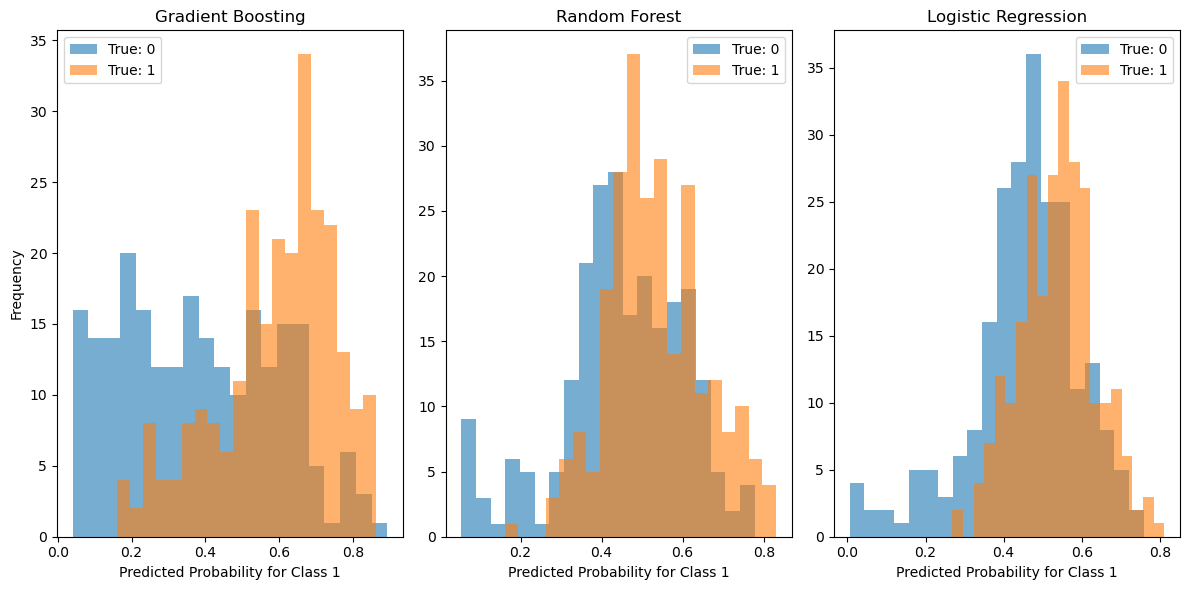

In [10]:
gb_class1_probs = gb_probs_cal[:, 1]
rf_class1_probs = rf_probs_cal[:, 1]
lr_class1_probs = lr_probs_cal[:, 1]

plt.figure(figsize=(12, 6))

# Gradient Boosting
plt.subplot(1, 3, 1)
plt.hist(gb_class1_probs[y_test == 0], bins=20, alpha=0.6, label='True: 0')
plt.hist(gb_class1_probs[y_test == 1], bins=20, alpha=0.6, label='True: 1')
plt.title('Gradient Boosting')
plt.xlabel('Predicted Probability for Class 1')
plt.ylabel('Frequency')
plt.legend()

# Random Forest
plt.subplot(1, 3, 2)
plt.hist(rf_class1_probs[y_test == 0], bins=20, alpha=0.6, label='True: 0')
plt.hist(rf_class1_probs[y_test == 1], bins=20, alpha=0.6, label='True: 1')
plt.title('Random Forest')
plt.xlabel('Predicted Probability for Class 1')
plt.legend()

# Logistic Regression
plt.subplot(1, 3, 3)
plt.hist(lr_class1_probs[y_test == 0], bins=20, alpha=0.6, label='True: 0')
plt.hist(lr_class1_probs[y_test == 1], bins=20, alpha=0.6, label='True: 1')
plt.title('Logistic Regression')
plt.xlabel('Predicted Probability for Class 1')
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
## Plot vs true label
from scipy.stats import pearsonr
lr_corr, _ = pearsonr(lr_class1_probs, y_test)
gb_corr, _ = pearsonr(gb_class1_probs, y_test)
rf_corr, _ = pearsonr(rf_class1_probs, y_test)

print(f"Pearson Correlation (Calibrated Logistic Regression): {lr_corr:.4f}")
print(f"Pearson Correlation (Calibrated Gradient Boosting): {gb_corr:.4f}")
print(f"Pearson Correlation (Calibrated Random Forest): {rf_corr:.4f}")


Pearson Correlation (Calibrated Logistic Regression): 0.3332
Pearson Correlation (Calibrated Gradient Boosting): 0.4928
Pearson Correlation (Calibrated Random Forest): 0.2989


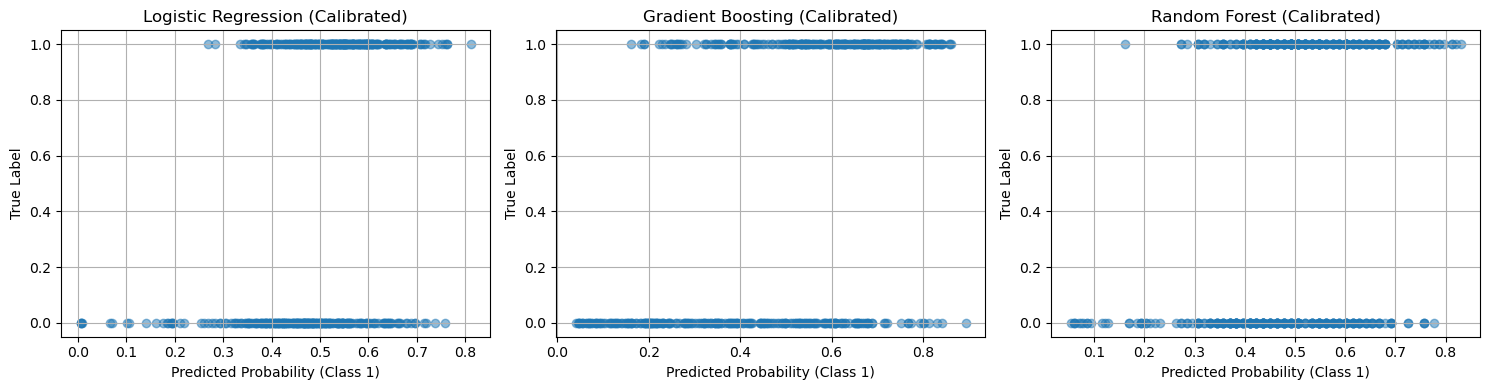

In [13]:
plt.figure(figsize=(15, 4))

# Logistic Regression
plt.subplot(1, 3, 1)
plt.scatter(lr_class1_probs, y_test, alpha=0.5)
plt.title('Logistic Regression (Calibrated)')
plt.xlabel('Predicted Probability (Class 1)')
plt.ylabel('True Label')
plt.grid(True)

# Gradient Boosting
plt.subplot(1, 3, 2)
plt.scatter(gb_class1_probs, y_test, alpha=0.5)
plt.title('Gradient Boosting (Calibrated)')
plt.xlabel('Predicted Probability (Class 1)')
plt.ylabel('True Label')
plt.grid(True)

# Random Forest
plt.subplot(1, 3, 3)
plt.scatter(rf_class1_probs, y_test, alpha=0.5)
plt.title('Random Forest (Calibrated)')
plt.xlabel('Predicted Probability (Class 1)')
plt.ylabel('True Label')
plt.grid(True)

plt.tight_layout()
plt.show()

In [17]:
gb_probs_df = pd.DataFrame(gb_probs_cal, columns=['prob_class_0', 'prob_class_1'])
gb_probs_df['true_label'] = y_test
# gb_probs_df

gb_preds = np.argmax(gb_probs_cal, axis=1)
accuracy = accuracy_score(y_test, gb_preds)
accuracy

0.7257731958762886

### MLP first pass

In [19]:
mlp = MLPClassifier(hidden_layer_sizes=(113,),
                    max_iter=33,
                    learning_rate_init=0.08,
                    solver='sgd',
                    batch_size=150,
                    random_state=42)
mlp.fit(X_train, y_train)

mlp_frozen = FrozenEstimator(mlp)

mlp_calibrated = CalibratedClassifierCV(estimator=mlp_frozen, cv=3, method='sigmoid')
mlp_calibrated.fit(X_calib, y_calib)
mlp_probs_cal = mlp_calibrated.predict_proba(X_test)

mlp_preds = np.argmax(mlp_probs_cal, axis=1)
accuracy = accuracy_score(y_test, mlp_preds)

print("Calibrated MLP Probabilities:\n", mlp_probs_cal[:5])
print(f"\nAccuracy on test set: {accuracy:.4f}")


Calibrated MLP Probabilities:
 [[0.51059309 0.48940691]
 [0.49759892 0.50240108]
 [0.49759892 0.50240108]
 [0.51059309 0.48940691]
 [0.49759892 0.50240108]]

Accuracy on test set: 0.5216


### 10 fold CV with calibration for GB

In [ ]:
fold_accuracies = []
gebv_records = []

# 50 total folds. Ensures representative use of dataset + 10 predictions for each oyster

for loop_idx in range(10):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=loop_idx)
    
    for fold_idx, (train_val_idx, test_idx) in enumerate(skf.split(X, y)):
        X_train_val, X_test = X[train_val_idx], X[test_idx]
        y_train_val, y_test = y[train_val_idx], y[test_idx]
        ids_train_val, ids_test = ids[train_val_idx], ids[test_idx]

        X_train, X_calib, y_train, y_calib, ids_train, ids_calib = train_test_split(
            X_train_val, y_train_val, ids_train_val, test_size=0.2,
            stratify=y_train_val, random_state=loop_idx
        )

        gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
        gb_model.fit(X_train, y_train)

        gb_frozen = FrozenEstimator(gb_model)
        calibrated_gb = CalibratedClassifierCV(estimator=gb_frozen, method='sigmoid')
        calibrated_gb.fit(X_calib, y_calib)

        y_probs = calibrated_gb.predict_proba(X_test)
        y_preds = np.argmax(y_probs, axis=1)
        acc = accuracy_score(y_test, y_preds)
        fold_accuracies.append(acc)

        # Record GEBVs with ID
        for id_val, true_label, prob_class1 in zip(ids_test, y_test, y_probs[:, 1]):
            gebv_records.append({
                'loop': loop_idx,
                'fold': fold_idx,
                'ID': id_val,
                'true_label': true_label,
                'gebv': prob_class1
            })

        print(f"Loop {loop_idx}, Fold {fold_idx}: Accuracy = {acc:.4f}")

print("\nAverage Accuracy over 50 folds:", np.mean(fold_accuracies))
print("Standard Deviation:", np.std(fold_accuracies))

gebv_df = pd.DataFrame(gebv_records)
gebv_df = gebv_df.sort_values('ID')
gebv_df.to_csv("gebv_df_GB.csv", index=False)
gebv_df


In [24]:
gb_corr_cv, _ = pearsonr(gebv_df["gebv"], gebv_df["true_label"])
print(f"Pearson Correlation (Calibrated 10 Fold Gradient Boosting): {gb_corr_cv:.4f}")

Pearson Correlation (Calibrated 10 Fold Gradient Boosting): 0.5173


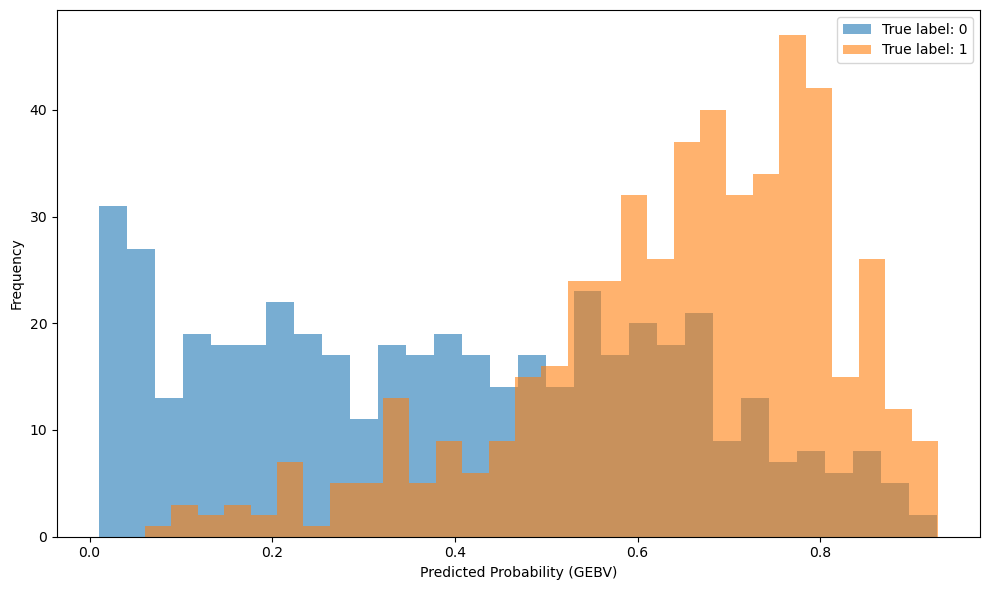

In [25]:
plt.figure(figsize=(10,6))
plt.hist(gebv_df[gebv_df['true_label'] == 0]['gebv'], bins=30, alpha=0.6, label='True label: 0')
plt.hist(gebv_df[gebv_df['true_label'] == 1]['gebv'], bins=30, alpha=0.6, label='True label: 1')

# plt.title('Histogram of Predicted GEBVs vs True Class')
plt.xlabel('Predicted Probability (GEBV)')
plt.ylabel('Frequency')
plt.legend()
# plt.grid(True)
plt.tight_layout()
plt.show()

#### Visualization of 10 fold GB GEBV calc

In [65]:
gebv_mean_df = pd.read_csv("gebv_df_GB.csv")
gebv_mean_df

loop  fold     ID  true_label      gebv
0         7     2    B-1         1.0  0.557211
1         2     2    B-1         1.0  0.457053
2         1     3    B-1         1.0  0.666679
3         4     4    B-1         1.0  0.584321
4         5     2    B-1         1.0  0.508664
...     ...   ...    ...         ...       ...
24225     0     2  Y_998         1.0  0.774174
24226     8     3  Y_998         1.0  0.724539
24227     9     3  Y_998         1.0  0.568063
24228     7     1  Y_998         1.0  0.819067
24229     2     2  Y_998         1.0  0.783334

[24230 rows x 5 columns]

In [66]:
gb_corr_cv, _ = pearsonr(gebv_mean_df["gebv"], gebv_mean_df["true_label"])
print(f"Pearson Correlation (Calibrated 50 (?) Fold Gradient Boosting): {gb_corr_cv:.4f}")

Pearson Correlation (Calibrated 50 (?) Fold Gradient Boosting): 0.4736


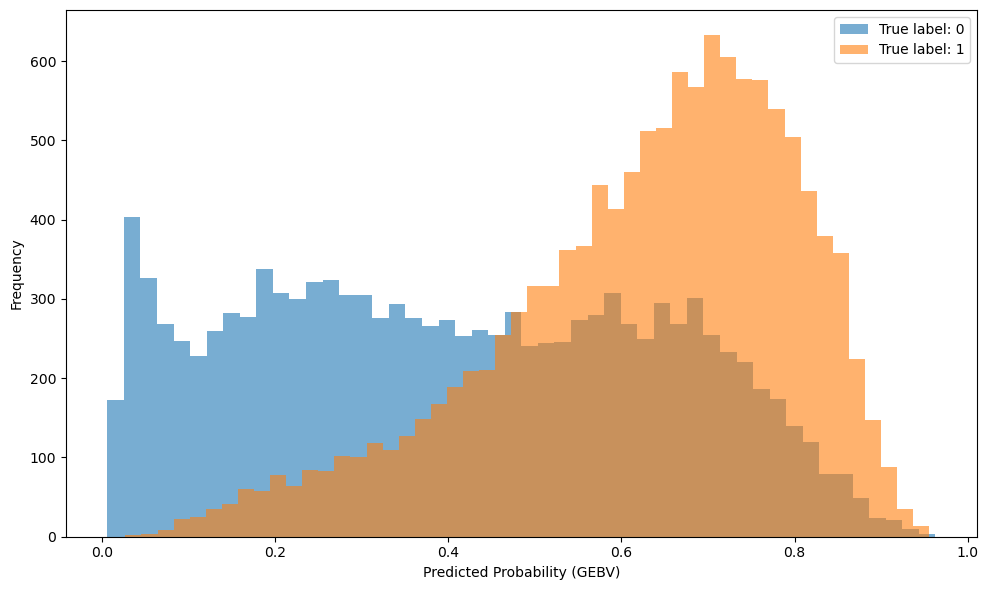

In [67]:
plt.figure(figsize=(10,6))
plt.hist(gebv_mean_df[gebv_mean_df['true_label'] == 0]['gebv'], bins=50, alpha=0.6, label='True label: 0')
plt.hist(gebv_mean_df[gebv_mean_df['true_label'] == 1]['gebv'], bins=50, alpha=0.6, label='True label: 1')

# plt.title('Histogram of Predicted GEBVs vs True Class')
plt.xlabel('Predicted Probability (GEBV)')
plt.ylabel('Frequency')
plt.legend()
# plt.grid(True)
plt.tight_layout()
plt.show()

In [68]:
gebv_mean_df = gebv_mean_df.groupby("ID").agg({
    "gebv": "mean",
    "true_label": "first"  # assumes true_label is consistent across folds
}).reset_index()

# Save if needed
# gebv_mean_df.to_csv("gebv_df_GB_mean.csv", index=False)
gebv_mean_df.rename(columns={'gebv': 'GB'}, inplace=True)
gebv_mean_df


ID        GB  true_label
0        B-1  0.548804         1.0
1     B-1000  0.059799         0.0
2     B-1002  0.171054         0.0
3     B-1003  0.621538         0.0
4     B-1005  0.216508         0.0
...      ...       ...         ...
2418   Y_988  0.680216         1.0
2419   Y_991  0.674903         1.0
2420   Y_992  0.671406         0.0
2421   Y_995  0.804664         1.0
2422   Y_998  0.732802         1.0

[2423 rows x 3 columns]

In [69]:
darpa = pd.read_csv("DarpaAllGebvV1.csv")
darpa
merged_df = pd.merge(darpa, gebv_mean_df, on='ID')
merged_df


ID  GBLUP_all  LASSO_all  RKHS_all  EGBLUP_all  BRR_all  BayesB  \
0        B-1      0.467      0.462     0.452     0.44227    0.464   0.367   
1     B-1000      0.438      0.441     0.420     0.42268    0.427   0.424   
2     B-1002      0.489      0.487     0.492     0.49212    0.485   0.509   
3     B-1003      0.521      0.526     0.527     0.50585    0.522   0.545   
4     B-1005      0.518      0.516     0.524     0.51249    0.517   0.457   
...      ...        ...        ...       ...         ...      ...     ...   
2350   Y_988      0.558      0.554     0.565     0.55304    0.543   0.549   
2351   Y_991      0.653      0.657     0.636     0.64423    0.661   0.615   
2352   Y_992      0.642      0.651     0.676     0.70335    0.658   0.649   
2353   Y_995      0.790      0.815     0.794     0.82042    0.813   0.829   
2354   Y_998      0.690      0.712     0.709     0.67006    0.703   0.698   

      Status        GB  true_label  
0          1  0.548804         1.0  
1          0  0.059799         0.0  
2          0  0.171054         0.0  
3          0  0.621538         0.0  
4          0  0.216508         0.0  
...      ...       ...         ...  
2350       1  0.680216         1.0  
2351       1  0.674903         1.0  
2352       0  0.671406         0.0  
2353       1  0.804664         1.0  
2354       1  0.732802         1.0  

[2355 rows x 10 columns]

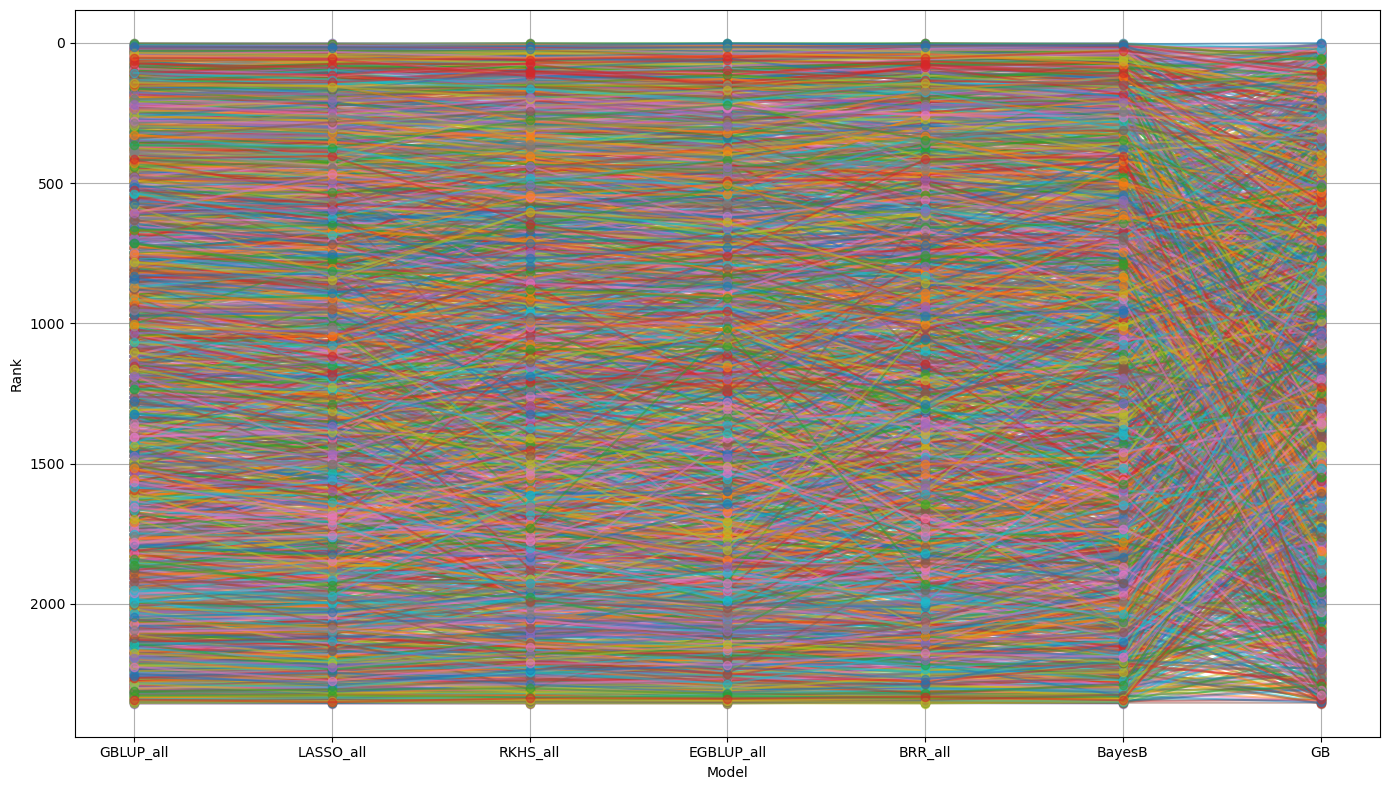

In [70]:
df_new = merged_df
df_new = df_new.drop('Status', axis=1)
df_new = df_new.drop('true_label', axis=1)

rank_only = df_new.set_index("ID").rank(ascending=False).astype(int)
rank_only = rank_only.reset_index()

# Melt to long format for plotting
rank_long = pd.melt(rank_only, id_vars='ID', var_name='Model', value_name='Rank')

# Plot
plt.figure(figsize=(14, 8))
for animal_id, group in rank_long.groupby("ID"):
    plt.plot(group['Model'], group['Rank'], marker='o', alpha=0.5)

plt.gca().invert_yaxis()  
plt.xlabel("Model")
plt.ylabel("Rank")
plt.grid(True)
plt.tight_layout()
plt.show()

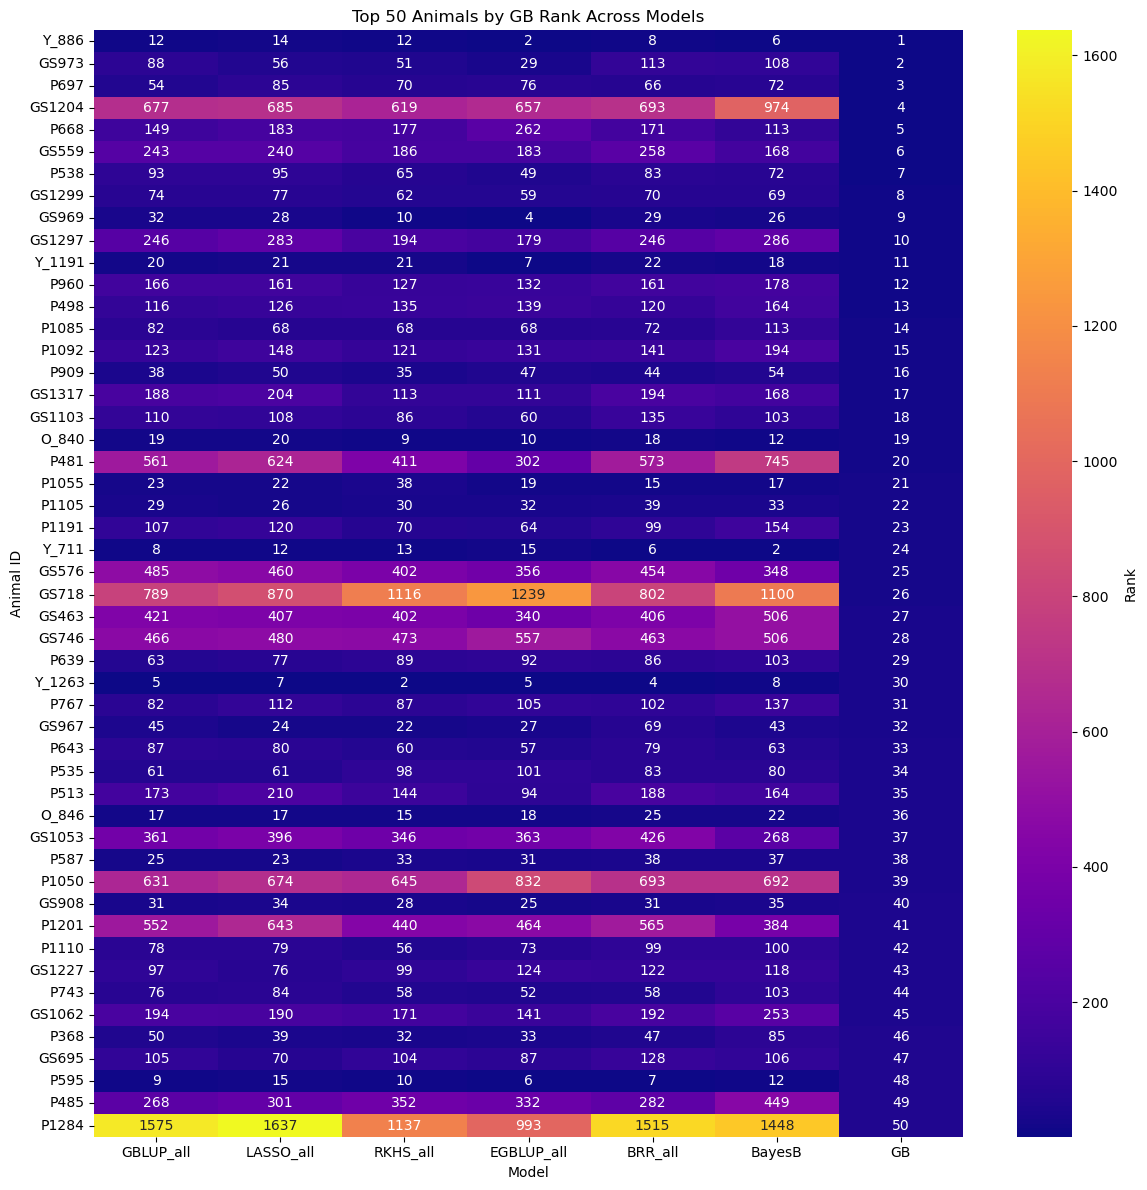

In [71]:
top_n = 50
subset = rank_only.sort_values("GB").head(top_n).set_index("ID")  # or use average rank
plt.figure(figsize=(12, 12))
sns.heatmap(subset, annot=True, cmap="plasma", fmt="d", cbar_kws={'label': 'Rank'})
plt.title(f"Top {top_n} Animals by GB Rank Across Models")
plt.ylabel("Animal ID")
plt.xlabel("Model")
plt.tight_layout()
plt.show()


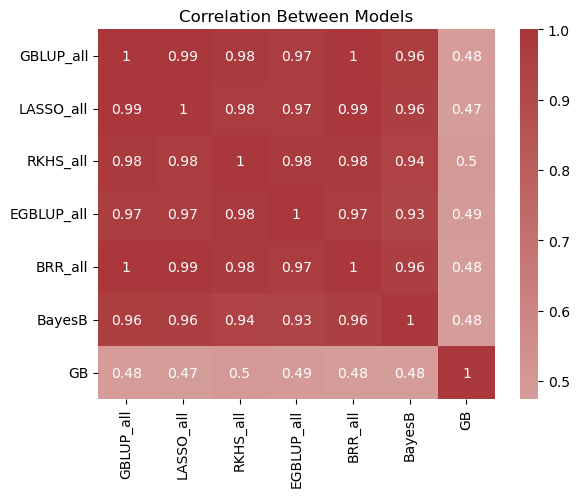

In [72]:
corr = rank_only.drop(columns='ID').corr(method='spearman')
sns.heatmap(corr, annot=True, cmap="vlag", center=0)
plt.title("Correlation Between Models")
plt.show()


In [73]:
rank_only['GB-RKHS'] = np.abs(rank_only['RKHS_all'] - rank_only['GB'])
rank_only
print(np.mean(rank_only['GB-RKHS']))

531.3953290870488


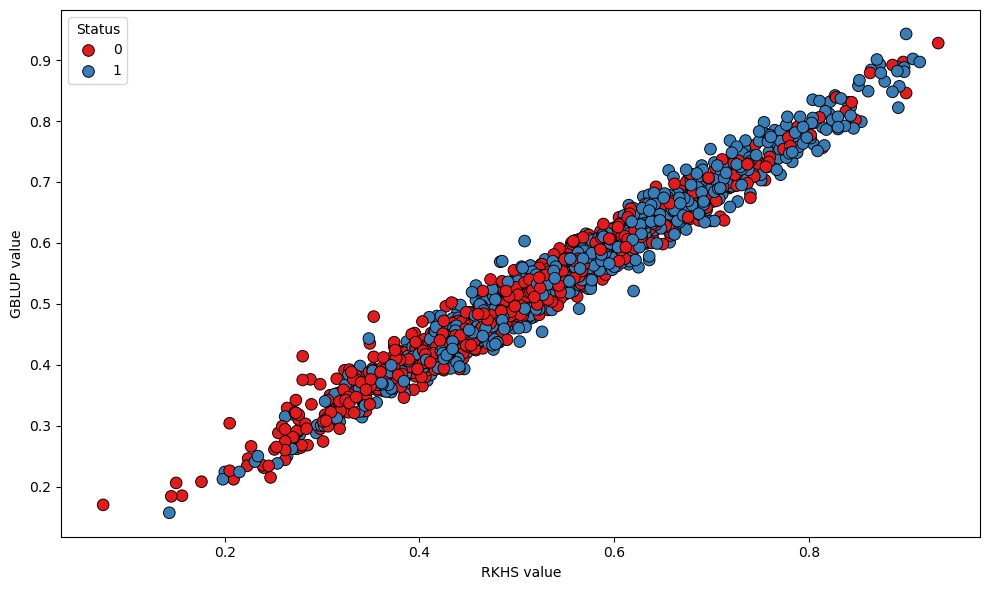

In [74]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=merged_df,
    x='RKHS_all', y='GBLUP_all', hue='Status', palette='Set1', edgecolor='k', s=70
)
# plt.xticks([], [])  # Hide x-axis tick labels if too many IDs
plt.ylabel("GBLUP value")
plt.xlabel("RKHS value")
plt.tight_layout()
plt.show()
# merged_df

In [75]:
pred_df = merged_df.copy()
model_columns = [col for col in pred_df.columns if col not in ['ID', 'true_label', 'Status']]  # adjust if 'Status' is used

for model in model_columns:
    pred_df[f"{model}_pred"] = (pred_df[model] > 0.5).astype(int)

accuracy_results = {}

for model in model_columns:
    preds = pred_df[f"{model}_pred"]
    acc = accuracy_score(pred_df['true_label'], preds)
    accuracy_results[model] = acc
    
accuracy_table = pd.DataFrame.from_dict(accuracy_results, orient='index', columns=['Accuracy'])
accuracy_table = accuracy_table.sort_values(by='Accuracy', ascending=False)
accuracy_table


Accuracy
GB          0.721868
BRR_all     0.591507
RKHS_all    0.591507
LASSO_all   0.585987
GBLUP_all   0.584713
EGBLUP_all  0.583015
BayesB      0.576645

In [76]:
positive_percentages = {}
for model in model_columns:
    pred_col = f"{model}_pred"
    percent_positive = pred_df[pred_col].mean() * 100  
    positive_percentages[model] = percent_positive
positive_table = pd.DataFrame.from_dict(positive_percentages, orient='index', columns=['% Positive Predictions'])
positive_table = positive_table.sort_values(by='% Positive Predictions', ascending=False)
print(positive_table)


            % Positive Predictions
GB                       63.014862
GBLUP_all                58.980892
RKHS_all                 58.641189
BayesB                   58.259023
BRR_all                  57.707006
LASSO_all                57.579618
EGBLUP_all               57.112527


In [79]:
########################## GPT

merged_df

# # Step 1: Prepare data
df = merged_df.copy()  # or whatever your aggregated GEBV DataFrame is called
label_col = 'true_label'  # or 'Status'

# Identify model columns
model_columns = [col for col in df.columns if col not in ['ID', 'Status', label_col]]

# Initialize result containers
full_stats = []
top10_stats = []

for model in model_columns:
    # Create binary predictions using GEBV threshold
    df[f"{model}_pred"] = (df[model] > 0.5).astype(int)

    # ---------- FULL DATA ----------
    total_pos_rate = df[label_col].mean() * 100
    model_pos_rate = df[f"{model}_pred"].mean() * 100

    full_stats.append({
        'Model': model,
        '% Predicted Positives': model_pos_rate,
        '% Actual Positives': total_pos_rate
    })

    # ---------- TOP 10% ----------
    top_n = int(len(df) * 0.1)
    df_sorted = df.sort_values(by=model, ascending=False).head(top_n)

    top_model_pos_rate = df_sorted[f"{model}_pred"].mean() * 100
    top_actual_pos_rate = df_sorted[label_col].mean() * 100

    top10_stats.append({
        'Model': model,
        '% Predicted Positives (Top 10%)': top_model_pos_rate,
        '% Actual Positives (Top 10%)': top_actual_pos_rate
    })

# Convert to DataFrames
full_stats_df = pd.DataFrame(full_stats).set_index('Model')
top10_stats_df = pd.DataFrame(top10_stats).set_index('Model')
print(full_stats_df)
print(top10_stats_df)

            % Predicted Positives  % Actual Positives
Model                                                
GBLUP_all               58.980892            53.29087
LASSO_all               57.579618            53.29087
RKHS_all                58.641189            53.29087
EGBLUP_all              57.112527            53.29087
BRR_all                 57.707006            53.29087
BayesB                  58.259023            53.29087
GB                      63.014862            53.29087
            % Predicted Positives (Top 10%)  % Actual Positives (Top 10%)
Model                                                                    
GBLUP_all                             100.0                     74.042553
LASSO_all                             100.0                     74.468085
RKHS_all                              100.0                     74.893617
EGBLUP_all                            100.0                     72.765957
BRR_all                               100.0                     74.042

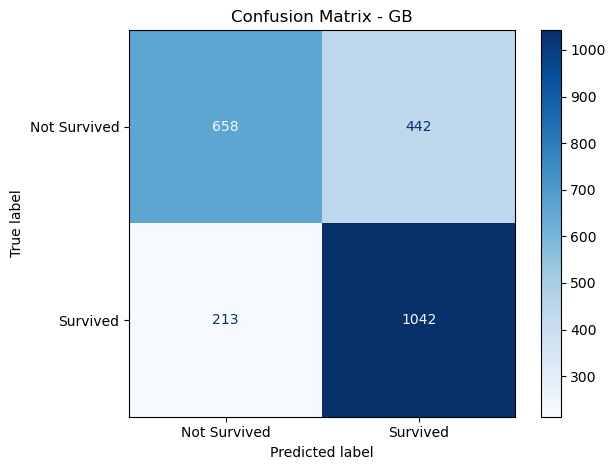

In [80]:
model = 'GB' # put column name in pred_df
true_labels = pred_df['Status']  # or 'Status'
pred_labels = (pred_df[model] > 0.5).astype(int)
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Survived', 'Survived'])

disp.plot(cmap='Blues', values_format='d')
plt.title(f"Confusion Matrix - {model}")
plt.tight_layout()
plt.show()
